In [1]:
!pip install pandas numpy matplotlib seaborn scikit-surprise nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505159 sha256=f75cd490579a8ca4e542fb15af29601df26905f78c4cb17fb19a0ed17027556e
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, KNNWithMeans, BaselineOnly
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [4]:
url_data = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
url_item = "http://files.grouplens.org/datasets/movielens/ml-100k/u.item"

# Load ratings data
column_names = ["user_id", "item_id", "rating", "timestamp"]
df = pd.read_csv(url_data, sep="\t", names=column_names)

# Load movie data
movie_columns = ["item_id", "title", "release_date", "video_release_date", "IMDb_URL",
                "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy",
                "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
                "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
df_movies = pd.read_csv(url_item, sep="|", names=movie_columns, encoding="latin-1")


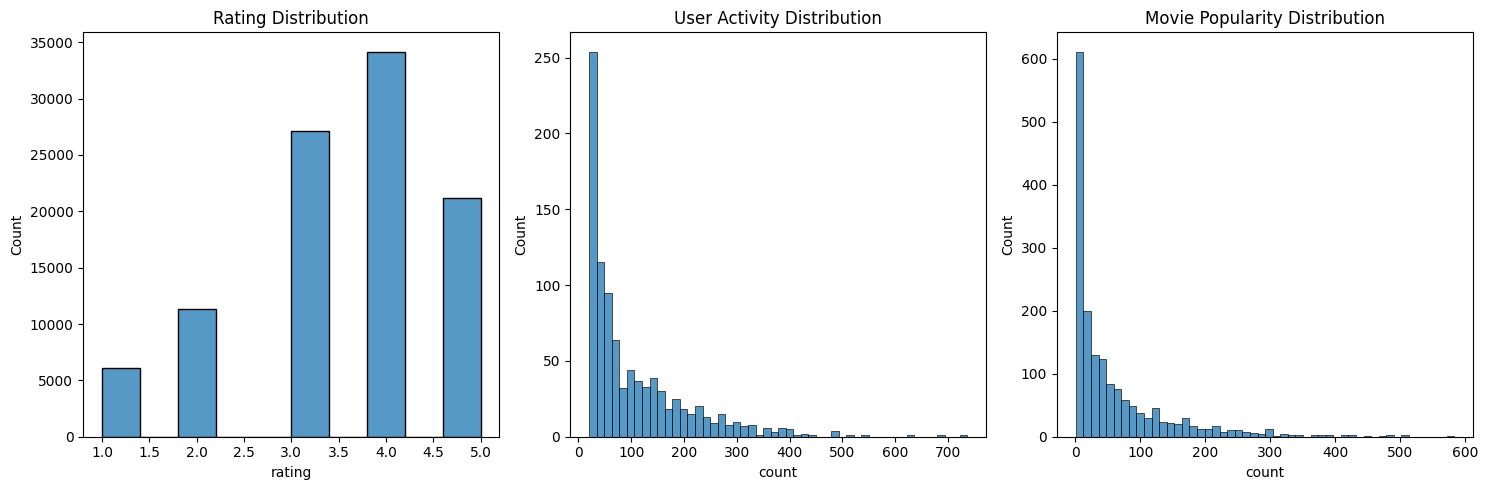

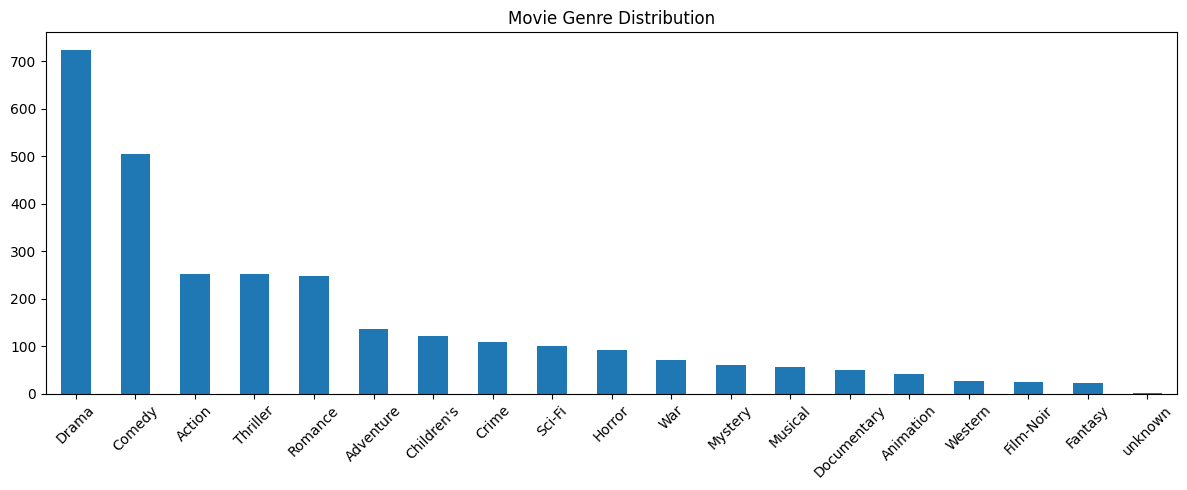

In [5]:
plt.figure(figsize=(15, 5))

# Rating distribution
plt.subplot(1, 3, 1)
sns.histplot(data=df, x='rating', bins=10)
plt.title('Rating Distribution')

# User activity distribution
plt.subplot(1, 3, 2)
user_ratings = df['user_id'].value_counts()
sns.histplot(data=user_ratings, bins=50)
plt.title('User Activity Distribution')

# Movie popularity
plt.subplot(1, 3, 3)
movie_ratings = df['item_id'].value_counts()
sns.histplot(data=movie_ratings, bins=50)
plt.title('Movie Popularity Distribution')

plt.tight_layout()
plt.show()

# Genre analysis
genre_cols = df_movies.columns[5:]
genre_counts = df_movies[genre_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
genre_counts.plot(kind='bar')
plt.title('Movie Genre Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
tfidf = TfidfVectorizer(stop_words='english')
title_matrix = tfidf.fit_transform(df_movies['title'])


In [7]:
# Create Surprise reader and dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[["user_id", "item_id", "rating"]], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Initialize models
svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
knn = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
baseline = BaselineOnly()

# Train collaborative filtering models
svd.fit(trainset)
knn.fit(trainset)
baseline.fit(trainset)

# Evaluate models
svd_predictions = svd.test(testset)
knn_predictions = knn.test(testset)
baseline_predictions = baseline.test(testset)

print("SVD RMSE:", accuracy.rmse(svd_predictions))
print("SVD MAE:", accuracy.mae(svd_predictions))
print("KNN RMSE:", accuracy.rmse(knn_predictions))
print("KNN MAE:", accuracy.mae(knn_predictions))
print("Baseline RMSE:", accuracy.rmse(baseline_predictions))
print("Baseline MAE:", accuracy.mae(baseline_predictions))


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9367
SVD RMSE: 0.9366789667241772
MAE:  0.7384
SVD MAE: 0.738383213923993
RMSE: 0.9208
KNN RMSE: 0.9207927118561658
MAE:  0.7206
KNN MAE: 0.7205620821620016
RMSE: 0.9442
Baseline RMSE: 0.9441798799352237
MAE:  0.7490
Baseline MAE: 0.7490029586981319


In [8]:
# New collaborative filtering algorithms
from surprise import KNNBasic, NMF

# Initialize new models
knn_basic = KNNBasic(k=50, sim_options={'name': 'cosine', 'user_based': False})
nmf = NMF(n_factors=100, n_epochs=20)

# Train new models
knn_basic.fit(trainset)
nmf.fit(trainset)

# Evaluate new models
knn_basic_predictions = knn_basic.test(testset)
nmf_predictions = nmf.test(testset)

print("KNN Basic RMSE:", accuracy.rmse(knn_basic_predictions))
print("KNN Basic MAE:", accuracy.mae(knn_basic_predictions))
print("NMF RMSE:", accuracy.rmse(nmf_predictions))
print("NMF MAE:", accuracy.mae(nmf_predictions))


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0249
KNN Basic RMSE: 1.0249468977728884
MAE:  0.8091
KNN Basic MAE: 0.8091040717775507
RMSE: 1.7784
NMF RMSE: 1.7784368223270446
MAE:  1.4195
NMF MAE: 1.419493575795948


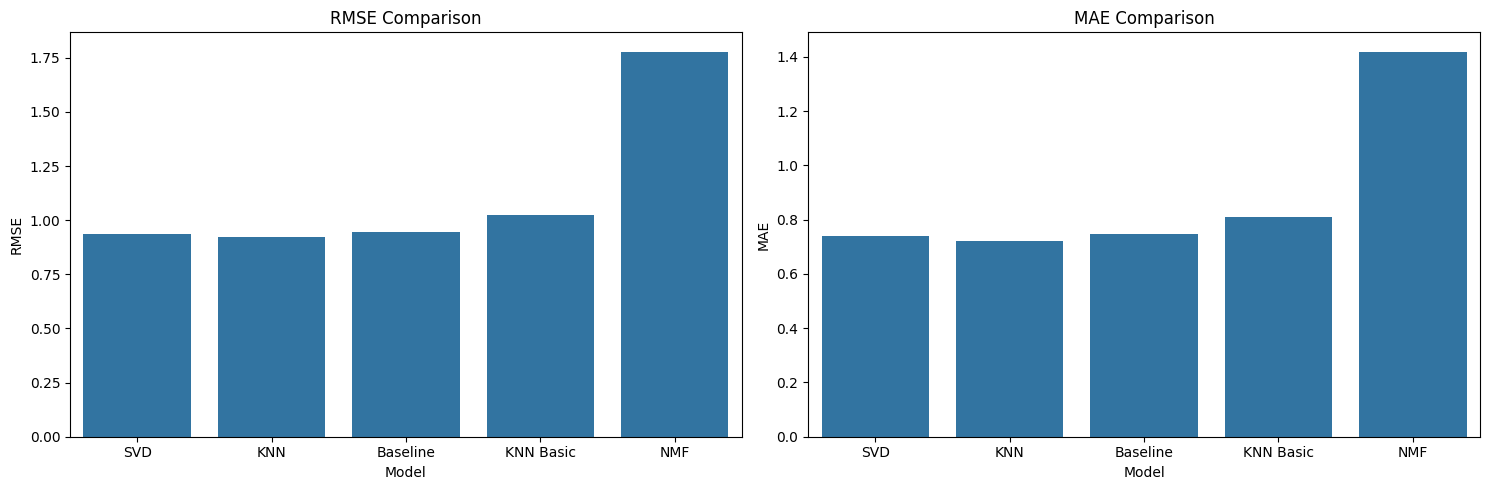

In [9]:
# Plot RMSE and MAE of all models
rmse_scores = [accuracy.rmse(svd_predictions, verbose=False),
               accuracy.rmse(knn_predictions, verbose=False),
               accuracy.rmse(baseline_predictions, verbose=False),
               accuracy.rmse(knn_basic_predictions, verbose=False),
               accuracy.rmse(nmf_predictions, verbose=False)]

mae_scores = [accuracy.mae(svd_predictions, verbose=False),
              accuracy.mae(knn_predictions, verbose=False),
              accuracy.mae(baseline_predictions, verbose=False),
              accuracy.mae(knn_basic_predictions, verbose=False),
              accuracy.mae(nmf_predictions, verbose=False)]

models = ['SVD', 'KNN', 'Baseline', 'KNN Basic', 'NMF']

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=models, y=rmse_scores)
plt.title('RMSE Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')

plt.subplot(1, 2, 2)
sns.barplot(x=models, y=mae_scores)
plt.title('MAE Comparison')
plt.xlabel('Model')
plt.ylabel('MAE')

plt.tight_layout()
plt.show()


In [10]:
# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(title_matrix, title_matrix)

# Function to get movie recommendations
def get_movie_recommendations(title, cosine_sim=cosine_sim_matrix):
    # Get index of the movie that matches the title
    idx = df_movies.index[df_movies['title'] == title].tolist()[0]

    # Get pairwise similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get indices of the most similar movies
    sim_indices = [i[0] for i in sim_scores[1:11]]

    return df_movies['title'].iloc[sim_indices]

# Example usage
print(get_movie_recommendations("Star Wars (1977)"))


513                          Annie Hall (1977)
666                         Audrey Rose (1977)
1090                      Pete's Dragon (1977)
1292                           Star Kid (1997)
123                           Lone Star (1996)
1060                  Evening Star, The (1996)
1264                          Star Maps (1997)
221            Star Trek: First Contact (1996)
379              Star Trek: Generations (1994)
449     Star Trek V: The Final Frontier (1989)
Name: title, dtype: object
